In [1]:
import numpy as np
import random
import h5py
import sys
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow import keras
from decimal import Decimal
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.layers import UpSampling2D, Cropping2D
from keras import models
from sklearn.metrics import accuracy_score

In [ ]:
# download file in lab3
!gdown --id 1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy
!gdown --id 1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt
!gdown --id 1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf
!gdown --id 1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf

In [ ]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020

In [2]:
clean_validation_data_filepath = "./content/valid.h5"
clean_test_data_filepath = "./content/test.h5"
bd_test_data_filepath = "./content/bd_test.h5"
# load data function
def data_loader(filepath):
  data = h5py.File(filepath, 'r')
  x_data = np.array(data['data'])
  y_data = np.array(data['label'])
  x_data = x_data.transpose((0,2,3,1))
  return x_data, y_data

# load data
x_clean_valid, y_clean_valid = data_loader(clean_validation_data_filepath)
x_clean_test, y_clean_test = data_loader(clean_test_data_filepath)
x_bd_test, y_bd_test = data_loader(bd_test_data_filepath)

# each class has a different int number index, get the biggest class's number
biggest_class_value = int(y_clean_valid.max())

In [3]:
# load model 
model_filepath = "./CSAW-HackML-2020/lab3/models/bd_net.h5"
bd_model = keras.models.load_model(model_filepath)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

2021-12-16 20:29:51.570693: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# get original accuracy
# predict on clean test data
pre_y = np.argmax(bd_model.predict(x_clean_test), axis=1)
original_acc = accuracy_score(pre_y, y_clean_test) *100
print(original_acc)

98.62042088854248


In [19]:
# get a structure copy of bd_model -> gd_model
gd_model = keras.models.clone_model(bd_model)
# load weights of bd_model to gd_model
gd_model.set_weights(bd_model.get_weights())

# we need to drop one channel in conv_3 each time
# get conv_3 layer in gd_model
conv_3 = gd_model.get_layer('conv_3')
# make conv_3 layer to individual intermediate model
intermediate = keras.Model(inputs=gd_model.input, outputs=gd_model.get_layer('conv_3').output)
# calculate the output(activation_values) of conv_3
activation_values = intermediate.predict(x_clean_valid).sum(axis=(0,1,2))
# get channel sort index according to the activation_values, delete the channel(from smallest activation_values to largest)
delete_channels_sort = np.argsort(activation_values)

channels = []
acc_list = []
count = 0
asr_list = []
three_drops_list = []
x_2, x_4, x_10 = 0, 0, 0

# delete channel one by one
# delete channel means set the channel's weights to zero
for i in range(len(delete_channels_sort)):
    count+=1
    if i % 2 == 0:# prevent RAM overflow, skip two at once
        new_channel = np.array(conv_3.get_weights()[0])
        new_channel[:, :, :, delete_channels_sort[i]] = np.zeros((3, 3, 40))
        conv_3.set_weights(list([new_channel, conv_3.get_weights()[1]]))
        continue
    # if the activation_values is too small(close to 0, no need to reset), skip it
    if activation_values[delete_channels_sort[i]] < 1e-3:
        continue
    # get conv_3 layer all channel's conv kernal parameters
    new_channel = np.array(conv_3.get_weights()[0])
    # set conv kernal parameters to zero according to delete_channels_sort's order
    new_channel[:, :, :, delete_channels_sort[i]] = np.zeros((3, 3, 40))
    # set modified conv_3 layer's weights
    # conv kernal parameters=new_channel(i.e. 0), bias=conv_3.get_weights()[1]
    conv_3.set_weights(list([new_channel, conv_3.get_weights()[1]]))

    # calculate bd_model(orign model) and gd_model's(conv_3 layer modified model) class acc on clean test set
    pred_bd = np.argmax(bd_model.predict(x_clean_test), axis=1)
    pred_gd = np.argmax(gd_model.predict(x_clean_test), axis=1)
    # if pred_bd[i] = pred_gd[i], then the channel is not useful, 
    # keep output[i] the same as original model.
    # if pred_bd[i] != pred_gd[i], then the channel is useful, 
    # make output[i] a wrong prediction(biggest class value+1)
    output_y = np.full(len(pred_bd), biggest_class_value+1)
    equal_mask = pred_bd == pred_gd
    output_y[equal_mask] = pred_bd[equal_mask]
    # fraction: how many channels have been modified
    # clean_accuracy: accuracy of current gd_model on clean test set
    # current gd_model means (modified channel fraction = count/(len(delete_channels_sort)))
    clean_accuracy = np.mean(np.equal(output_y, y_clean_test))*100
    print(
        'fraction is ',count/(len(delete_channels_sort)),
        'Clean Classification ac',clean_accuracy
    )
    channels.append(count/(len(delete_channels_sort)))
    acc_list.append(clean_accuracy)


    # calculate attack success rate, use bad test set
    pred_bd = np.argmax(bd_model.predict(x_bd_test), axis=1)
    pred_gd = np.argmax(gd_model.predict(x_bd_test), axis=1)
    # same calculation as output_y
    output_y_att = np.full(len(pred_bd), biggest_class_value+1)
    equal_mask_att = pred_bd == pred_gd
    output_y_att[equal_mask_att] = pred_bd[equal_mask_att]
    # Attack success: accuracy on bad test set is lower than original accuracy
    asr = np.mean(np.equal(output_y_att, y_bd_test))*100
    asr_list.append(asr)
    print('Attack Success Rate:', asr)

fraction is  0.5333333333333333 Clean Classification ac 98.61262665627436
Attack Success Rate: 100.0
fraction is  0.5666666666666667 Clean Classification ac 98.60483242400623
Attack Success Rate: 100.0
fraction is  0.6 Clean Classification ac 98.58924395947
Attack Success Rate: 100.0
fraction is  0.6333333333333333 Clean Classification ac 98.57365549493376
Attack Success Rate: 100.0
fraction is  0.6666666666666666 Clean Classification ac 98.45674201091192
Attack Success Rate: 100.0
fraction is  0.7 Clean Classification ac 98.0826188620421
Attack Success Rate: 100.0
fraction is  0.7333333333333333 Clean Classification ac 97.54481683554171
Attack Success Rate: 100.0
fraction is  0.7666666666666667 Clean Classification ac 95.47155105222136
Attack Success Rate: 99.97661730319564
fraction is  0.8 Clean Classification ac 94.61418550272798
Attack Success Rate: 99.97661730319564
fraction is  0.8333333333333334 Clean Classification ac 92.34606391270461
Attack Success Rate: 79.69602494154326
fra

In [20]:
# save the result(clean_accuracy and asr) of specified(i.e output X={2%,4%,10%}) gd_model on clean test set
acc_array = np.array(acc_list)
asr_array = np.array(asr_list)
for TH in [2,4,10]:
    mask = original_acc - acc_array >= TH
    three_drops_list.append((acc_array[mask][0], asr_array[mask][0]))

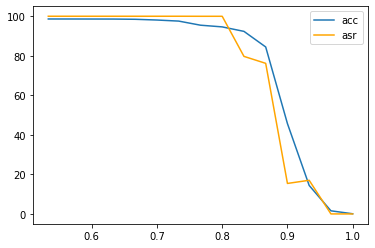

In [21]:
plt.plot(channels,acc_list,label = 'acc')
plt.plot(channels,asr_list,color = 'orange', label = 'asr')
plt.legend()

In [22]:
#output the accuricy and asr when drops = {2%,4%,10%}
drops = [2,4,10]
for i in range(len(drops)):
    print('When drops = ',drops[i],'%','the accuracy is ',three_drops_list[i][0], 'and the asr is ',three_drops_list[i][1])

When drops =  2 % the accuracy is  95.47155105222136 and the asr is  99.97661730319564
When drops =  4 % the accuracy is  94.61418550272798 and the asr is  99.97661730319564
When drops =  10 % the accuracy is  84.45830085736556 and the asr is  76.1730319563523
